## Goal of the notebook: calculate fitness effect of insertion mutations in DM25 and write DFE data to file

Input Data:
- mutant trajectories: number of counts at each TA site at every time point for each population. 

### PLEASE DOWNLOAD DATA FROM ZENODO INTO DATA FOLDER, FILES ARE TOO LARGE FOR GITHUB

Analysis Approach:
- Calculate fitness effects of disrupting genes by linear fit to log frequency vs time. Average over TA sites in the interior of the gene. (require at least x number of TA sites for which we calculate fitness)
- If no fitness is calculated, set value as -1
- Correct the fitness effect of each gene with an internal control: the average effect of disrupting pseudogenes
- Do a pairwise comparison of the ancestor vs each population: if there is no fitness calculated in one of the strains, repeat fitness calculation with a less strict set of thresholds.
- Calculate the means and variance of the DFEs for each population, also estimate error in the mean and variance.

Output:
- fitness_gene_corrected: (genes x libraries x 2 replicates) inverse-variance weighted average of fitness effect of disrupting gene at insertion sites in the interior
- fitness_relaxed: (genes x libraries x 2 replicates) same as above except I calculate fitness effects for genes using relaxed thresholds
- means/variance/errors in estimates of DFE for each population

#### NOTE: I have commented out all the places where I write images or data to file, please uncomment and rewrite data if you'd like to mess with parameters and redo the analysis

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from Bio.SeqIO.FastaIO import SimpleFastaParser
import re
import pandas as pd
import seaborn as sns

In [2]:
from matplotlib import cm
from statsmodels.stats.multitest import multipletests
from scipy.stats import beta, gamma,lognorm, poisson
import matplotlib.patches as mpatches

In [3]:
import pathlib
import os

In [4]:
#current working directory
cwd = os.getcwd()
print(cwd)

/Users/anuraglimdi/Desktop/TnSeq_Paper/LTEE-TnSeq_Paper/Analysis/Part_3_TnSeq_analysis/Fitness_estimation


In [5]:
#use the pathlib.Path function to get the parent directories-> goal is to navigate to directory with the metadata
# and the breseq output data
path = pathlib.Path(cwd)
repo = str(path.parents[2])
print(path.parents[2]) #this should be the base directory for the github repository: the exact path will differ for 
#each unique user

/Users/anuraglimdi/Desktop/TnSeq_Paper/LTEE-TnSeq_Paper


### Please make sure that the output of the previous cell is the path where you have cloned the github repository

In [6]:
metadata_path = repo+'/Metadata/'
#data_path = repo+'/Data/Mutant_Trajectories/'

In [7]:
#input directory with all the counts data
directory = repo+'/Data/Mutant_Trajectories/'
#names of libraries
libraries = ['REL606', 'REL607', 'REL11330', 'REL11333', 'REL11364', 'REL11336', 'REL11339', 'REL11389', 'REL11392', 'REL11342', 'REL11345', 'REL11348', 'REL11367', 'REL11370']
#more interpretable names for the figures in the paper
libraries2 = ['REL606', 'REL607', 'Ara-1', 'Ara-2', 'Ara-3', 'Ara-4', 'Ara-5', 'Ara-6', 'Ara+1', 'Ara+2', 'Ara+3', 'Ara+4', 'Ara+5', 'Ara+6']

In [8]:
#opening the pandas file with all the metadata!
all_data = pd.read_csv(metadata_path+"all_metadata_REL606.txt", sep="\t")
names = all_data.iloc[:,0]
gene_start = all_data.iloc[:,3]
gene_end = all_data.iloc[:,4]
strand = all_data.iloc[:,5]
locations = np.transpose(np.vstack([gene_start,gene_end,strand]))
k12_tags = all_data.iloc[:,2]
uniprot_rel606 = all_data.iloc[:,6]

locations_pseudogenes = np.loadtxt(metadata_path+'pseudogenes_locations_REL606.txt')


In [9]:
#list of genes to be excluded from analysis as they lie within large deletions
exclude_genes = np.loadtxt(repo+"/Analysis/Part_2_WGS_analysis/Deleted_genes_REL606_k12annotated.txt")

exclude_pseudogenes = np.loadtxt(repo+"/Analysis/Part_2_WGS_analysis/Deleted_pseudogenes_REL606_k12annotated.txt")

n_pseudo = exclude_pseudogenes.shape[1]

#fractions of the gene at the 5' and 3' ends to be excluded from analysis because they insertions there may not actually
#be disruptive to protein function
frac5p = 0.1
frac3p = 0.25

In [10]:
savepath = repo+'/Analysis/Part_3_TnSeq_analysis/Processed_data_for_plotting/'#path where I'm saving data such as fitness, fraction, etc. 

In [11]:
with open(metadata_path+"rel606_reference.fasta") as in_handle:
    for title, seq in SimpleFastaParser(in_handle):
        ta_sites = [m.start(0) for m in re.finditer('TA', seq)]
ta_sites = np.array(ta_sites)

#counting how many TA sites are present in each gene
ta_gene = np.zeros(len(names))
for i in range(0,len(names)):
    start = locations[i, 0]
    end = locations[i, 1]
    length = end - start
    #if the gene is on the forward strand
    if locations[i,2]==1:
        #counting sites only in the middle 80% of the gene, excluding 10% at each end
        ta_gene[i] = np.sum((ta_sites > start+length*frac5p)&(ta_sites < end - length*frac3p))
    elif locations[i,2]==-1:
        ta_gene[i] = np.sum((ta_sites < start+length*frac5p)&(ta_sites > end - length*frac3p))

In [15]:
#all the information from the fitness assay condensed into a couple of matrices
counts_all_green = np.zeros([len(libraries), 5, len(ta_sites)])
counts_all_red = np.zeros([len(libraries), 5, len(ta_sites)])

for k in range(len(libraries)):
    #loading the new file where I have the counts for each TA site for all time points
    gname = directory+'green_'+libraries[k]+'_merged_all_TAsites.txt'
    greendata = np.loadtxt(gname)
    rname = directory+'red_'+libraries[k]+'_merged_all_TAsites.txt'
    reddata = np.loadtxt(rname)
    #now for extracting the UMI corrected coutns
    counts_all_green[k,:,:] = greendata[2:11:2,:]
    counts_all_red[k,:,:] = reddata[2:11:2,:]

### Part 1: Calculating fitness effects in all populations

In [16]:
#normalized counts data for each sample:
greensum = np.sum(counts_all_green,axis=2)
redsum = np.sum(counts_all_red, axis=2)
#fraction of sites above threshold
fraction_t0 = np.zeros([len(names),len(libraries)])-1

In [17]:
#timepoint where we look at the fraction of sites that are present in the dataset
t_comp = 0
site_thresh = 5
ta_min = 5
#not using this data directly, but will be needed later when we are inferring gene essentiality

In [18]:
#first step, counting the number of TA sites above the threshold at the comparison timepoint for all the populations
for k in range(len(libraries)):
    for i in range(len(names)):
        #if the gene is present in this genetic background, and there are at least 5 TA sites in the gene
        if exclude_genes[k,i] == 0 and ta_gene[i] >=ta_min:
            start = locations[i, 0]
            end = locations[i, 1]
            length = end - start
            #if the gene is on the forward strand
            if locations[i,2]==1:
                search_area = (ta_sites > start+length*frac5p)&(ta_sites < end - length*frac3p)
            #if the gene is on the reverse strand
            elif locations[i,2]==-1:
                search_area = (ta_sites < start+length*frac5p)&(ta_sites > end - length*frac3p)
            green = np.sum(counts_all_green[k,t_comp,search_area]/greensum[k,t_comp]*10**7 > site_thresh)
            red = np.sum(counts_all_red[k,t_comp,search_area]/redsum[k,t_comp]*10**7 > site_thresh)
            fraction_t0[i,k] = (green+red)/np.abs(ta_gene[i])/2

### Saving data: fraction of sites above coverage threshold, used later for gene essentiality estimation and more

In [19]:
fname = savepath+f'fraction_t0_site_thresh_{site_thresh}_ta_min_{ta_min}.txt'
# np.savetxt(savepath+f'fraction_t0_site_thresh_{site_thresh}_ta_min_{ta_min}.txt', fraction_t0)

### Important Functions for fitness estimation:
- search_gene: returns the coordinates of TA sites that lie within the interior of any gene
- inverse_var_weight: returns the inverse variance weights a given N_0, N_1
- fitness_estimate: calculates fitness estimate and measurement error for a gene

In [20]:
def search_gene(locations,ta_sites,i):
    start = locations[i, 0]
    end = locations[i, 1]
    length = end - start
    #if the gene is on the forward strand
    if locations[i,2]==1:
        search_area = (ta_sites > start+length*frac5p)&(ta_sites < end - length*frac3p)
    #if the gene is on the reverse strand
    elif locations[i,2]==-1:
        search_area = (ta_sites < start+length*frac5p)&(ta_sites > end - length*frac3p)
    return search_area

#following the weights definition from 
def inverse_var_weight(n0,n1):
    
    return (((1+n0)**-1 + (1+n1)**-1)/np.log(2)**2)**-1

#### Quick summary of the function:

- Restrict analysis to genes that are not lost, and have at least 5 TA sites in the interior
- For every interior TA site, calculate the fitness effect by fitting a line to log(frequency) vs time
- If trajectory dies out (i.e. counts = 0), then set that timepoint to 1 (a pseudocount), and do a linear fit of log(frequency) vs time, upto that specific time-point
- If there are at least 2 surviving trajectories in each replicate, then use an inverse variance weighting approach to get the average effect of disrupting the gene.
- Estimate uncertainty in the fitness measurement using a few different metrics (discussed below): for the paper, we use an inverse variance weighted SEM


#### Note about convention: if no fitness is calculated for a gene, its value is set to -1: this is simply so it allows me to keep track of where thresholds were met or not

In [21]:
#calculating fitnesses
def fitness_estimate(counts_red, counts_green, locs, genes_lost, initial_depth, min_sites, min_frac, max_reads, t_start, t_end):
    """
    data:
    - counts_red, counts_green: trajectories for both replicates
    - exclude: filtering out genes that are lost/have too few sites from analysis as they're indicated as -1
    params:
    - locs: start and end points of genes
    - initial_depth: exclude sites below a certain threshold in fitness estimation
    - min_sites: minimum number of sites required for estimating fitness for each replicate
    - min_frac: fraction of TA sites that need to considered in estimating fitness
    - site_thresh: minimum number of reads for a trajectory to be included (strictly greater than)
    - max_reads: maximum reads that can be used for inverse variance estimate
    
    """
    green = np.sum(counts_green,axis=1)
    red = np.sum(counts_red, axis=1)
    #fitness effect (best estimate)
    fitness_inverse_var = np.zeros([len(genes_lost),2])-1
    #three different metrics of measurement error
    stderr_fitness = np.zeros([len(genes_lost)])-1
    stderr_fitness_inverse_var = np.zeros([len(genes_lost)])-1
    stderr_fitness_hybrid = np.zeros([len(genes_lost)])-1
    #defining time interval based on gene essentiality status:
    time_gens = np.linspace(t_start,t_end,t_end-t_start+1)*6.64
    
    #iterating over all genes that are not lost over evolution
    for gene in np.where(genes_lost==0)[0] :
        #TA sites within this gene
        search_area = search_gene(locations=locs, ta_sites=ta_sites, i=gene)
        #weights
        weights_green = []
        weights_red = []
        #fitnesses
        s_green = []
        s_red = []
        
        ta = np.sum(search_area==True)
        #now, iterating over sites with at least tm1_depth reads at t-1:
        for j in np.where((search_area==True))[0]:
            if (counts_green[t_start,j]/green[t_start]*10**7>initial_depth) & (counts_red[t_start,j]/red[t_start]*10**7>initial_depth):
                #extracting the trajectories
                traj_green = counts_green[t_start:t_end+1,j]/green[t_start:t_end+1]*10**7
                traj_red = counts_red[t_start:t_end+1,j]/red[t_start:t_end+1]*10**7
                n_0 = traj_green[0]
                n_after_g = traj_green[1]
                n_after_r = traj_red[1]
                #this part is different:
                #i'll find the first occurrence of zero if at all, and then fit a trajectory upto that point
                #green replicate first
                if 0 not in traj_green:
                    sg = np.polyfit(time_gens, np.log(traj_green), 1)[0]
                    wg = min(inverse_var_weight(n_0, n_after_g), inverse_var_weight(max_reads, max_reads))
                    #sotring the data
                    weights_green.append(wg)
                    s_green.append(sg)
                else:
                    #first zero in the gren dataset:
                    ind_g = int(np.where(traj_green==0)[0][0])
                    counts_g = traj_green[:ind_g+1].copy()
                    #add a pseudocount to the first occurrence of zero
                    counts_g[-1] = 1
                    sg = np.polyfit(time_gens[:ind_g+1], np.log(counts_g), 1)[0]
                    wg = min(inverse_var_weight(n_0, n_after_g), inverse_var_weight(max_reads, max_reads))
                    #storing the data
                    weights_green.append(wg)
                    s_green.append(sg)
                
                #now the red replicate
                if 0 not in traj_red:
                    sg = np.polyfit(time_gens, np.log(traj_red), 1)[0]
                    wg = min(inverse_var_weight(n_0, n_after_r), inverse_var_weight(max_reads, max_reads))
                    #sotring the data
                    weights_red.append(wg)
                    s_red.append(sg)
                else:
                    #first zero in the red dataset:
                    ind_g = int(np.where(traj_red==0)[0][0])
                    counts_g = traj_red[:ind_g+1].copy()
                    #add a pseudocount to the first occurrence of zero
                    counts_g[-1] = 1
                    sg = np.polyfit(time_gens[:ind_g+1], np.log(counts_g), 1)[0]
                    wg = min(inverse_var_weight(n_0, n_after_r), inverse_var_weight(max_reads, max_reads))
                    #storing the data
                    weights_red.append(wg)
                    s_red.append(sg)
                
        #converting to numpy arrays
        s_green = np.array(s_green)
        s_red = np.array(s_red)
        weights_green = np.array(weights_green)
        weights_red = np.array(weights_red)
        
        #pooling over all sites, require minimum number of sites, and fraction of sites represented
        if min(len(s_green),len(s_red))>=min_sites and min(len(s_green),len(s_red))/ta>=min_frac:

            #weighing based on inverse variacne:
            fitness_inverse_var[gene,0] = np.average(s_green, weights=weights_green)
            fitness_inverse_var[gene,1] = np.average(s_red, weights=weights_red)
            
            #standard error in fitness estimates:
            stderr_fitness[gene] = np.std(np.hstack([s_green,s_red]))/np.sqrt(len(s_green)+len(s_red)-1)
            #-1 is for the unbiased estimator
            
            #inverse variance weighted standard error measurement
            stacked_s = np.hstack([s_green,s_red])
            stacked_w = np.hstack([weights_green,weights_red])
            
            average = np.average(stacked_s, weights=stacked_w)
            sem_inv = np.sqrt(np.average((stacked_s-average)**2, weights=stacked_w)/(len(stacked_s)-1))
            sem_hybrid = np.sqrt(np.average((stacked_s-average)**2)/(len(stacked_s)-1))
            
            #saving the inverse variance wieghted measurements.
            stderr_fitness_inverse_var[gene] = sem_inv
            #saving the hyrid measurement errors
            stderr_fitness_hybrid[gene] = sem_hybrid
            
    return fitness_inverse_var, stderr_fitness, stderr_fitness_inverse_var, stderr_fitness_hybrid

In [22]:
#parameters for filtering out noisy data and selecting which time points to use in analysis
min_sites = 2
min_frac = 0.2
#timepoints to compare:
# change this depending on the analysis you want to do!
t0 = 0
t1 = 4
time_range = np.linspace(t0,t1,t1-t0+1)*6.64
tm1_depth = 5

#### Please note that I experimented with three different metrics of error in the fitness estimates.

Note that the mean fitness of a gene is calculated as an inverse variance weighted average ($\mu_{inv} = \sum(w_{i}s_{i})$)

- option 1: the standard error (using the builtin numpy function): this is the least precise, as it'll automatically calculate the mean without weighting in the sem calculation. $\sum(x_{i} - \mu_{uncorrected})^{2}$
- option 2: the inverse variance weighted standard error: in the sem calculation, weigh replicates by the same amount as they were in calculating the mean (this is the one that is the most appropriate in our analysis). $\sum(s_{i} - \mu_{uncorrected})^{2}w_{i}$, where $w_{i}$ are the weights assigned to the different TA sites within the gene
- option 3: hybrid standard error: no weights, but instead of $\sum(s_{i} - \mu_{uncorrected})^{2}$, we use $\sum(s_{i} - \mu_{inv})^{2}$

We went with option 2 as it takes into account the fact that we don't believe all our fitness measurements within a gene equally, and places less value on the inherently noisier ones in estimating uncertainty in the true fitness effect. Also note that this choice does not impact our results in a meaningful way.

In [23]:
s_inverse_var = np.zeros([len(names),len(libraries),2])-1
s_inverse_pseudo = np.zeros([n_pseudo,len(libraries),2])-1

#the three different error metrics
standard_error = np.zeros([len(names),len(libraries)])-1
standard_error_inv = np.zeros([len(names),len(libraries)])-1
standard_error_hybrid = np.zeros([len(names),len(libraries)])-1

#the three different error metrics
standard_error_pseudo = np.zeros([n_pseudo,len(libraries)])-1
standard_error_pseudo_inv = np.zeros([len(names),len(libraries)])-1
standard_error_pseudo_hybrid = np.zeros([len(names),len(libraries)])-1

for k in range(0,len(libraries)):
    #now I'm going to call the function which actually runs the code for estimating fitness
    fitness_inverse_var, pop_error, pop_error_inv, pop_error_hybrid = fitness_estimate(counts_all_green[k,:,:], counts_all_red[k,:,:], 
                                                           genes_lost=exclude_genes[k,:], locs=locations, initial_depth=tm1_depth,
                                                           min_frac=min_frac,max_reads=100,
                                                           min_sites=min_sites, t_start=t0, t_end=t1)
    #runnning the function for the pseudogenes
    fitness_inverse_var_pseudogenes, pop_error_pseudo, pop_error_pseudo_inv, pop_error_pseudo_hybrid = fitness_estimate(counts_all_green[k,:,:], counts_all_red[k,:,:], 
                                                            genes_lost=exclude_pseudogenes[k,:],
                                                           locs=locations_pseudogenes,initial_depth=tm1_depth,
                                                           min_frac=min_frac,max_reads=100,
                                                           min_sites=min_sites, t_start=t0, t_end=t1)
        
    #genes in the analysis:
    genes_analyzed = np.where(fitness_inverse_var[:,0]>-1)[0]
    
    #pseudogenes in the analysis
    pseudogenes_analyzed = np.where(fitness_inverse_var_pseudogenes[:,0]>-1)[0]
    
    #calculating the mean correction factor for each populaiton, not excluding outliers:
    mean_correction_inv_var = np.mean(fitness_inverse_var_pseudogenes[pseudogenes_analyzed,:], axis=0)

    #saving the fitness estimates for the genes
    s_inverse_var[genes_analyzed, k, 0] = fitness_inverse_var[genes_analyzed, 0]
    s_inverse_var[genes_analyzed, k, 1] = fitness_inverse_var[genes_analyzed, 1]
    
#     s_inverse_var[np.where(np.abs(pvals_fdr[:,k]<ess_thresh)), k, :] = -2
    
    #saving the pseudogenes fitness estimates:
    s_inverse_pseudo[:,k,:] = fitness_inverse_var_pseudogenes
    #unweighted error estimates
    standard_error[genes_analyzed, k] = pop_error[genes_analyzed]
    standard_error_pseudo[pseudogenes_analyzed, k] = pop_error_pseudo[pseudogenes_analyzed]
    #inverse variance weighted error estimates
    standard_error_inv[genes_analyzed, k] = pop_error_inv[genes_analyzed]
    standard_error_pseudo_inv[pseudogenes_analyzed, k] = pop_error_pseudo_inv[pseudogenes_analyzed]
    #hybrid error estimates
    standard_error_hybrid[genes_analyzed, k] = pop_error_hybrid[genes_analyzed]
    standard_error_pseudo_hybrid[pseudogenes_analyzed, k] = pop_error_pseudo_hybrid[pseudogenes_analyzed]

In [24]:
s_inverse_var_copy = np.copy(s_inverse_var)
print(np.min(s_inverse_var==s_inverse_var_copy))

True


#### Correcting the fitness estimates by subtracting the mean effect of disrupting pseudogenes that have fitness effects near neutrality.

- Note that some pseudogenes can have highly deleterious effects, potentially due to polar effects.
- For Ara-2, all the fitness estimates are biased due to a few mutants taking over and the bulk of the uncorrected DFE is concentrated around -0.2, so there are no pseudogenes with an uncorrected fitness of +/- 0.05

In [25]:
run_once = 0

In [26]:
while run_once==0:
    for k in range(0, len(libraries)):
        #handling all populations except ara-2
        if k not in [3]:
            genes_analyzed = np.where(s_inverse_var[:,k,0]>-1)[0]
            pseudogenes_analyzed = np.where((s_inverse_pseudo[:,k,0]>-0.05)&(s_inverse_pseudo[:,k,1]>-0.05))[0]
            corrections = np.mean(s_inverse_pseudo[pseudogenes_analyzed,k,:],axis=0)
            print(corrections, libraries[k])
            #correcting the estimates by replicate
            s_inverse_var[genes_analyzed, k, 0] = s_inverse_var[genes_analyzed, k, 0] - corrections[0]
            s_inverse_var[genes_analyzed, k, 1] = s_inverse_var[genes_analyzed, k, 1] - corrections[1]
        #because a-2 has some mutations fix, pseudogenes are around -19%
        #so I;m requiring that the fitnesses > -0.05
        else:
            genes_analyzed = np.where(s_inverse_var[:,k,0]>-1)[0]
            #pseudogenes in the analysis
            pseudogenes_analyzed = np.where(s_inverse_pseudo[:,k,0]>-1)[0]
            corrections = np.mean(s_inverse_pseudo[pseudogenes_analyzed,k,:],axis=0)
            #correcting the estimates by replicate
            s_inverse_var[genes_analyzed, k, 0] = s_inverse_var[genes_analyzed, k, 0] - corrections[0]
            s_inverse_var[genes_analyzed, k, 1] = s_inverse_var[genes_analyzed, k, 1] - corrections[1]
    run_once=1

[-0.0087086  -0.00636075] REL606
[-0.01023422 -0.0100438 ] REL607
[-0.00725029 -0.00512881] REL11330
[-0.00495299 -0.00657039] REL11364
[-0.00751923 -0.00780591] REL11336
[-0.00699322 -0.00589254] REL11339
[-0.01184721 -0.01206626] REL11389
[-0.00337866 -0.00263297] REL11392
[-0.00553487 -0.00680097] REL11342
[-0.0077014  -0.00696454] REL11345
[-0.01199336 -0.00900709] REL11348
[-0.00712573 -0.00686453] REL11367
[-0.01362303 -0.02072889] REL11370


### Saving data: This is the fitness estimates for all genes/pseudogenes, and the errors in the fitness estimates (which are computed slightly differently)

In [27]:
fname1 = savepath+f'fitness_corrected_genes'
fname2 = savepath+f'errors_genes'
fname3 = savepath+f'fitness_pseudogenes'
fname4 = savepath+f'errors_pseudogenes'

fname5 = savepath+f'errors_genes_inv'
fname6 = savepath+f'errors_pseudogenes_inv'

fname7 = savepath+f'errors_genes_hybrid'
fname8 = savepath+f'errors_pseudogenes_hybrid'


#saving the files now:
# np.save(fname1, s_inverse_var)
# np.save(fname2, standard_error)
# np.save(fname3, s_inverse_pseudo)
# np.save(fname4, standard_error_pseudo)
# np.save(fname5, standard_error_inv)
# np.save(fname6, standard_error_pseudo_inv)
# np.save(fname7, standard_error_hybrid)
# np.save(fname8, standard_error_pseudo_hybrid)

In [235]:
#just sanity checking some data
s_inverse_var[list(names).index('sspA')]

array([[-0.32309008, -0.26881478],
       [-0.24791682, -0.34827508],
       [-0.13660168, -0.02533479],
       [-0.03299209, -0.01883153],
       [-0.18254041, -0.16316946],
       [-0.07390178, -0.08912543],
       [-0.10089448, -0.07464315],
       [-0.15432662, -0.17637027],
       [-0.06192539, -0.06884853],
       [-0.08027262, -0.09543254],
       [-0.08000855, -0.04871196],
       [-0.2952767 , -0.16504088],
       [-0.05312648, -0.0402353 ],
       [-0.18650211, -0.17968245]])

### Data for Figure 2: DFE does not change despite frequent epistatic interactions between genetic background and insertion mutations 

Save the data in a dataframe format so it is easy to use seaborn to make a ridgeplot

In [29]:
#creating the consolidated pandas dataframe for all the data and the metadata
dfe_data_all_inverse_var= pd.DataFrame()
#mutator status of each population
mutator = ['non-mutator', 'non-mutator', 'mutator', 'mutator', 'mutator', 'mutator', 'non-mutator', 'non-mutator'
           , 'non-mutator', 'non-mutator', 'mutator', 'non-mutator', 'non-mutator', 'mutator']
#ara phenotype
ara_minus = [0,2,3,4,5,6,7]

In [30]:
for k in range(len(libraries)):
    #had this stupid looking if condition to remove Ara-2 and Ara+4 from analysis very quickly without changing much
    if k not in [103,1011]:
        next1=pd.DataFrame()
        next2=pd.DataFrame()
        noness_pop = np.where(s_inverse_var[:,k,0]>-1)[0]
        if k<2:
            #replicate 1
            #here, I'm correcting for the average fitness estimate for a pseudogene in that technical replicate
            next1["Fitness estimate"] = s_inverse_var[noness_pop,k,0]
            next1["Population"] = libraries2[k]
            next1["Evolutionary History"] = "Ancestral"
            next1["Replicate"] = "Green"
            next1["Genes"] = names[noness_pop]
            next1["Mutator"] = mutator[k]
            
            #replicate 2
            next2["Fitness estimate"] = s_inverse_var[noness_pop,k,1]
            next2["Population"] = libraries2[k]
            next2["Evolutionary History"] = "Ancestral"
            next2["Replicate"] = "Red"
            next2["Genes"] = names[noness_pop]
            next2["Mutator"] = mutator[k]

        else:
            #replicate 1
            next1["Fitness estimate"] = s_inverse_var[noness_pop,k,0]
            next1["Population"] = libraries2[k]
            next1["Evolutionary History"] = "Evolved"
            next1["Replicate"] = "Green"
            next1["Genes"] = names[noness_pop]
            next1["Mutator"] = mutator[k]

            #replicate 2
            next2["Fitness estimate"] = s_inverse_var[noness_pop,k,1]
            next2["Population"] = libraries2[k]
            next2["Evolutionary History"] = "Evolved"
            next2["Replicate"] = "Red"
            next2["Genes"] = names[noness_pop]
            next2["Mutator"] = mutator[k]

        if k in ara_minus:
            next1["Ara Phenotype"] = "Ara-"
            next2["Ara Phenotype"] = "Ara-"
        else:
            next1["Ara Phenotype"] = "Ara+"
            next2["Ara Phenotype"] = "Ara+"
        dfe_data_all_inverse_var = dfe_data_all_inverse_var.append(next1, ignore_index=True)
        dfe_data_all_inverse_var = dfe_data_all_inverse_var.append(next2, ignore_index=True)

/var/folders/f8/92wybs9d7wqfthlqj1drht_c0000gn/T/ipykernel_20642/3217383995.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfe_data_all_inverse_var = dfe_data_all_inverse_var.append(next1, ignore_index=True)
/var/folders/f8/92wybs9d7wqfthlqj1drht_c0000gn/T/ipykernel_20642/3217383995.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfe_data_all_inverse_var = dfe_data_all_inverse_var.append(next2, ignore_index=True)
/var/folders/f8/92wybs9d7wqfthlqj1drht_c0000gn/T/ipykernel_20642/3217383995.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfe_data_all_inverse_var = dfe_data_all_inverse_var.append(next1, ignore_index=True)
/var/folders/f8/92wybs9d7wqfthlqj1drht_c0000gn/T/ipykernel_20642/3217383995.py:49: FutureWa

In [31]:
fname = savepath+f'dfe_data_pandas.csv'
# dfe_data_all_inverse_var.to_csv(fname)

In [32]:
means_dfe = np.zeros(len(libraries))
var_dfe = np.zeros(len(libraries))

In [33]:
for k in range(len(libraries)):
    rep1 = s_inverse_var[:,k,0][s_inverse_var[:,k,0]>-1]
    rep2 = s_inverse_var[:,k,1][s_inverse_var[:,k,1]>-1]
    means_dfe[k] = np.mean([rep1,rep2])
    var_dfe[k] = np.var([rep1,rep2])

### Now that we have the means and variances of the DFE, I will calculate the uncertainty in the mean and variances, given the measurement noise in fitness effect of each gene. Please see the methods section of the paper for the exact formulae.

In [179]:
def error_mean_dfe(gene_errors, pseudogene_errors):
    error = np.zeros(len(libraries))
    for k in range(len(libraries)):
        genes_analyzed = gene_errors[:,k]>-1
        pseudogenes_analyzed = pseudogene_errors[:,k]>-1
        gene_contribution = np.sum(gene_errors[genes_analyzed,k]**2)/sum(genes_analyzed)**2
        pseudogene_contribution = np.sum(pseudogene_errors[pseudogenes_analyzed,k]**2)/sum(pseudogenes_analyzed)**2
        error[k] = np.sqrt(gene_contribution+pseudogene_contribution)
    
    return error

In [180]:
error_mean = error_mean_dfe(standard_error, standard_error_pseudo)

In [181]:
error_mean_inv = error_mean_dfe(standard_error_inv, standard_error_pseudo_inv)

In [182]:
error_mean_hybrid = error_mean_dfe(standard_error_hybrid, standard_error_pseudo_hybrid)

In [230]:
def error_var_dfe(gene_errors, pseudo_errors, fitness, fitness_pseudo, means_DFE, error_mean):
    error = np.zeros(len(libraries))
    for k in range(len(libraries)):
        #pseudogenes
        pseudo_analyzed = np.where(pseudo_errors[:,k]>-0.1)[0]
        M = len(pseudo_analyzed)
        pseudo_mean = np.mean(fitness_pseudo[pseudo_analyzed, k, :],axis=1)
        #genes analyzed
        genes_analyzed = np.where(gene_errors[:,k]>-1)[0]
        N = len(genes_analyzed)
        fitness_mean = np.mean(fitness[genes_analyzed, k, :],axis=1)
        #coefficients
        coeff = 2/N*(fitness_mean - means_DFE[k])
        #errors
        term1 = np.sum(gene_errors[genes_analyzed,k]**2*coeff**2)
        
        error[k] = np.sqrt(term1)
    return error

In [231]:
error_var = error_var_dfe(standard_error,standard_error_pseudo, s_inverse_var, s_inverse_pseudo, means_dfe, error_mean)

In [232]:
error_var_inv = error_var_dfe(standard_error_inv,standard_error_pseudo_inv, s_inverse_var, s_inverse_pseudo, means_dfe, error_mean_inv)

In [233]:
error_var_hybrid = error_var_dfe(standard_error_hybrid,standard_error_pseudo_hybrid, s_inverse_var, s_inverse_pseudo, means_dfe, error_mean_hybrid)

In [185]:
fname1 = savepath+f'mean_dfe.txt'
fname2 = savepath+f'variance_dfe.txt'
fname3 = savepath+f'error_mean.txt'
fname4 = savepath+f'error_variance.txt'

#saving the files now:
# np.savetxt(fname1, means_dfe)
# np.savetxt(fname2, var_dfe)
# np.savetxt(fname3, error_mean)
# np.savetxt(fname4, error_var)

In [186]:
fname5 = savepath+f'error_mean_inv.txt'
fname6 = savepath+f'error_variance_inv.txt'

# np.savetxt(fname5, error_mean_inv)
# np.savetxt(fname6, error_var_inv)

In [187]:
fname7 = savepath+f'error_mean_hybrid.txt'
fname8 = savepath+f'error_variance_hybrid.txt'

# np.savetxt(fname7, error_mean_hybrid)
# np.savetxt(fname8, error_var_hybrid)

## Part 2: Calculating fitness effects using relaxed thresholds
- It is possible that differences in populations (whether a gene is calculated or not) are due to arbitrariness of the thresholds. 
- Now, for every gene that has a fitness calculated with the strict thresholds in at least one population, I'll recalculate fitness with more relaxed requirements for how many TA sites are needed per gene.
- If a fitness effect is not calculated even with relaxed thresholds, only then will I try to make an assessment of whether there is differential essentiality in LB



In [78]:
def s_gene_pairwise(counts_red,counts_green,pop1,pop2,gene):
    """
    pop1: where gene is not calculated
    pop2: where gene is calculated
    """
    green = np.sum(counts_green,axis=1)
    red = np.sum(counts_red, axis=1)
    
    #doing this only for one gene
    fitness_inverse_var = np.zeros(2)-1
    stderr_fitness = -1
    #TA sites within this gene
    search_area = search_gene(locations=locations, ta_sites=ta_sites, i=gene)
    #weights
    weights_green = []
    weights_red = []
    #fitnesses
    s_green = []
    s_red = []
    #defining time interval based on gene essentiality status:
    t_start = 0
    t_end = 4
    time_gens = np.linspace(t_start,t_end,t_end-t_start+1)*6.64
    max_reads=100
    ta = np.sum(search_area==True)
    #now, iterating over sites with at least tm1_depth reads at t-1:
    for j in np.where((search_area==True))[0]:
        if counts_green[0,j]/green[0]*10**7>tm1_depth:
            #extracting the trajectories
            traj_green = counts_green[t_start:t_end+1,j]/green[t_start:t_end+1]*10**7
            traj_red = counts_red[t_start:t_end+1,j]/red[t_start:t_end+1]*10**7
            #
            n_0 = traj_green[0]
            n_after_g = traj_green[1]
            n_after_r = traj_red[1]
            #this part is different:
            #i'll find the first occurrence of zero if at all, and then fit a trajectory upto that point
            #green replicate first
            if 0 not in traj_green:
                sg = np.polyfit(time_gens, np.log(traj_green), 1)[0]
                wg = min(inverse_var_weight(n_0, n_after_g), inverse_var_weight(max_reads, max_reads))
                #sotring the data
                weights_green.append(wg)
                s_green.append(sg)
            else:
                #first zero in the red dataset:
                ind_g = int(np.where(traj_green==0)[0][0])
                counts_g = traj_green[:ind_g+1].copy()
                #add a pseudocount to the first occurrence of zero
                counts_g[-1] = 1
                sg = np.polyfit(time_gens[:ind_g+1], np.log(counts_g), 1)[0]
                wg = min(inverse_var_weight(n_0, n_after_g), inverse_var_weight(max_reads, max_reads))
                #storing the data
                weights_green.append(wg)
                s_green.append(sg)
            #now the red replicate
            if 0 not in traj_red:
                sg = np.polyfit(time_gens, np.log(traj_red), 1)[0]
                wg = min(inverse_var_weight(n_0, n_after_r), inverse_var_weight(max_reads, max_reads))
                #sotring the data
                weights_red.append(wg)
                s_red.append(sg)
            else:
                #first zero in the red dataset:
                ind_g = int(np.where(traj_red==0)[0][0])
                counts_g = traj_red[:ind_g+1].copy()
                #add a pseudocount to the first occurrence of zero
                counts_g[-1] = 1
                sg = np.polyfit(time_gens[:ind_g+1], np.log(counts_g), 1)[0]
                wg = min(inverse_var_weight(n_0, n_after_r), inverse_var_weight(max_reads, max_reads))
                #storing the data
                weights_red.append(wg)
                s_red.append(sg)

    #converting to numpy arrays
    s_green = np.array(s_green)
    s_red = np.array(s_red)
    weights_green = np.array(weights_green)
    weights_red = np.array(weights_red)

    #pooling over all sites, note the relaxed thresholds
    if min(len(s_green),len(s_red))>=1 and min(len(s_green),len(s_red))/ta>=0.1:

        #weighing based on inverse variacne:
        fitness_inverse_var[0] = np.average(s_green, weights=weights_green)
        fitness_inverse_var[1] = np.average(s_red, weights=weights_red)

        #standard error in fitness estimates:
        stderr_fitness = np.std(np.hstack([s_green,s_red]))/np.sqrt(len(s_green)+len(s_red))

    return fitness_inverse_var, stderr_fitness

In [79]:
#making a copy of the fitness estimates
s_inverse_var_relaxed = np.copy(s_inverse_var)

First, for every gene that has a fitness calculated in the evolved clone, try and calculate a fitness effect in the ancestor REL606 using the relaxed thresholds

In [81]:
non_ess_cutoff = -0.2
cutoffs = np.ones(14)*-0.3
for k in range(1,len(libraries)):
    #only considering pseudogenes which have a fitness of -0.05 or higher. SOme appear deleterious, presumably
    #from polar effects
    anc_num = 0
    #correction factors for fitness estimation.
    pseudogenes_analyzed = np.where((s_inverse_pseudo[:,anc_num,0]>-0.05)&(s_inverse_pseudo[:,anc_num,1]>-0.05))[0]
    corrections_anc = np.mean(s_inverse_pseudo[pseudogenes_analyzed,anc_num,:],axis=0)

    #exclude ara-2 from analysis
    if k!=3:
        #counter variables
        count=0
        print(libraries[k])
        #extracting genes that are -1 in ancestor and near neutral in the evolved population
        ess_anc = np.where((np.mean(s_inverse_var[:,anc_num,:],axis=1)==-1)&(np.mean(s_inverse_var[:,k,:],axis=1)>non_ess_cutoff))[0]
        
        #relaxed thresholds
        for gene in ess_anc:
            s_relaxed, std_relaxed = s_gene_pairwise(counts_all_green[anc_num,:,:], counts_all_red[anc_num,:,:],anc_num,k,gene)
            #updating the relaxed fitness estimates array for the ancestor (gene was -1 in ancestor):
            s_inverse_var_relaxed[gene,anc_num,:] = s_relaxed - corrections_anc*(np.mean(s_relaxed)!=-1)
            #updating the counter
            if np.mean(s_relaxed)>cutoffs[anc_num]:
                count+=1
            else:
                print('anc',np.round(np.mean(s_relaxed),3),libraries[k],np.round(np.mean(s_inverse_var[gene,k,:]),3),gene)
                
        print(np.size(ess_anc),f'Number of genes not calculated in anc but calculated in {libraries[k]}',
              count)


REL607
anc -1.0 REL607 0.016 913
anc -1.0 REL607 -0.003 1054
anc -1.0 REL607 -0.095 1791
27 Number of genes not calculated in anc but calculated in REL607 24
REL11330
anc -1.0 REL11330 0.014 295
anc -1.0 REL11330 -0.114 357
anc -1.0 REL11330 -0.108 358
anc -1.0 REL11330 -0.2 848
anc -1.0 REL11330 -0.06 913
anc -0.378 REL11330 -0.059 1837
anc -1.0 REL11330 -0.092 1926
anc -1.0 REL11330 -0.192 2139
anc -1.0 REL11330 -0.0 2242
anc -1.0 REL11330 -0.063 3134
anc -1.0 REL11330 -0.063 3244
40 Number of genes not calculated in anc but calculated in REL11330 29
REL11364
anc -1.0 REL11364 -0.044 547
anc -1.0 REL11364 -0.197 622
anc -1.0 REL11364 -0.074 924
anc -1.0 REL11364 -0.15 1054
anc -1.0 REL11364 -0.177 1120
anc -1.0 REL11364 -0.166 1228
anc -1.0 REL11364 -0.005 1315
anc -1.0 REL11364 -0.057 1366
anc -1.0 REL11364 -0.014 1926
anc -0.55 REL11364 -0.162 3588
40 Number of genes not calculated in anc but calculated in REL11364 30
REL11336
anc -1.0 REL11336 -0.01 1054
anc -1.0 REL11336 -0.127 1

In [82]:
for k in range(1,len(libraries)):
    anc_num = 0
    #correction factors for fitness estimation.
    pseudogenes_analyzed = np.where((s_inverse_pseudo[:,k,0]>-0.05)&(s_inverse_pseudo[:,k,1]>-0.05))[0]
    corrections_ev = np.mean(s_inverse_pseudo[pseudogenes_analyzed,k,:],axis=0)
    if k!=3:
        count2=0
        print(libraries[k])
        #the following statement means: gene is not calculated in the evolved clone, but calculated in the ancestor
        #with the relaxed thresholds for number of TA sites etc., and that the gene is not lost over evolution
        ess_ev = np.where((np.mean(s_inverse_var[:,k,:],axis=1)==-1)&(np.mean(s_inverse_var_relaxed[:,anc_num,:],axis=1)>non_ess_cutoff)&(exclude_genes[k,:]==0))[0]
        
        for gene in ess_ev:
            s_relaxed, std_relaxed = s_gene_pairwise(counts_all_green[k,:,:], counts_all_red[k,:,:],k,anc_num,gene)
            #updating the relaxed fitness estimates array for the evolved (gene was -1 in evolved):
            s_inverse_var_relaxed[gene,k,:] = s_relaxed - corrections_ev*(np.mean(s_relaxed)!=-1)
            if np.mean(s_relaxed)>cutoffs[k]:
                count2+=1
            else:
                print(libraries[k],np.round(np.mean(s_relaxed),3),'anc',np.round(np.mean(s_inverse_var_relaxed[gene,anc_num,:]),3),gene)
        
        print(np.size(ess_ev),f'Number of genes  calculated in anc but not calculated in {libraries[k]}',
              count2)

REL607
REL607 -0.306 anc -0.077 379
REL607 -1.0 anc -0.039 922
REL607 -1.0 anc -0.12 1026
REL607 -1.0 anc -0.004 1138
REL607 -1.0 anc -0.082 1782
REL607 -1.0 anc -0.044 1958
REL607 -1.0 anc -0.001 3202
REL607 -1.0 anc -0.034 3460
REL607 -1.0 anc 0.023 3811
REL607 -1.0 anc -0.003 3911
57 Number of genes  calculated in anc but not calculated in REL607 47
REL11330
REL11330 -1.0 anc -0.083 764
REL11330 -1.0 anc -0.151 835
REL11330 -1.0 anc -0.094 1850
REL11330 -1.0 anc -0.044 1958
REL11330 -1.0 anc -0.066 2750
REL11330 -1.0 anc -0.001 3202
REL11330 -0.302 anc -0.004 3899
REL11330 -0.313 anc -0.003 3911
40 Number of genes  calculated in anc but not calculated in REL11330 32
REL11364
REL11364 -1.0 anc -0.094 86
REL11364 -0.345 anc 0.015 235
REL11364 -1.0 anc 0.007 302
REL11364 -1.0 anc -0.107 390
REL11364 -1.0 anc -0.11 751
REL11364 -1.0 anc 0.002 843
REL11364 -1.0 anc 0.013 1293
REL11364 -1.0 anc -0.195 1376


/Users/anuraglimdi/anaconda3/envs/sns_env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/anuraglimdi/anaconda3/envs/sns_env/lib/python3.9/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


REL11364 -1.0 anc -0.002 3457
REL11364 -1.0 anc -0.032 3716
37 Number of genes  calculated in anc but not calculated in REL11364 27
REL11336
REL11336 -1.0 anc -0.094 86
REL11336 -1.0 anc -0.028 335
REL11336 -1.0 anc -0.151 835
REL11336 -1.0 anc 0.002 843
REL11336 -1.0 anc -0.157 999
REL11336 -1.0 anc -0.063 1059
REL11336 -1.0 anc -0.117 1060
REL11336 -1.0 anc -0.151 1071
REL11336 -1.0 anc -0.004 1138
REL11336 -1.0 anc -0.118 1172
REL11336 -1.0 anc -0.197 1174
REL11336 -1.0 anc 0.013 1293
REL11336 -1.0 anc -0.076 1686
REL11336 -1.0 anc -0.168 1939
REL11336 -1.0 anc -0.091 2101
REL11336 -1.0 anc 0.003 2206
REL11336 -1.0 anc -0.167 2244
REL11336 -1.0 anc -0.135 2326
REL11336 -0.353 anc -0.059 2763
REL11336 -1.0 anc -0.127 2937
REL11336 -1.0 anc -0.198 3138
REL11336 -1.0 anc 0.004 3432
REL11336 -1.0 anc -0.002 3433
REL11336 -1.0 anc -0.056 3435
REL11336 -1.0 anc -0.047 3436
REL11336 -1.0 anc -0.108 3802
REL11336 -1.0 anc -0.028 3886
REL11336 -1.0 anc -0.003 3911
67 Number of genes  calcula

In [83]:
fname = savepath+f'fitness_genes_relaxed_thresholds_updated'
# np.save(fname,s_inverse_var_relaxed)

### Outputting additional data:

- trajectories for rffG and rffH
- p_vals_fdr (just for making the figure on defining essentiality in LB, not anything more)


In [87]:
loc_rffg = locations[list(names).index('rffG'),:]
loc_rffh = locations[list(names).index('rffH'),:]
# np.save(savepath+'rffH_trajectories', counts_all_red[:,:,search_gene(locations,ta_sites,list(names).index('rffH'))])
# np.save(savepath+'rffG_trajectories', counts_all_red[:,:,search_gene(locations,ta_sites,list(names).index('rffG'))])

In [240]:
counts_all_red[:,:,search_gene(locations,ta_sites,list(names).index('rffH'))].shape

(14, 5, 20)

### p-vals fdr calculation for estimating gene essentiality in LB

In [89]:
likelihood_noness_gamma = np.ones([len(names),len(libraries)])*-1
#parameters for the fitting of gamma distribution:
fit_domain = 0.3

for k in range(len(libraries)):
    #this is the data that will go into the fitting functions
    data = fraction_t0[:,k]
    a, loc, scale_noness = stats.gamma.fit(data[data>=fit_domain])
    mu, var = stats.norm.fit(data[(data>=fit_domain)])
    likelihood_noness_gamma[data>-1,k] = stats.gamma.cdf(data[data>-1],a,loc,scale_noness)


In [91]:
pvals_fdr = np.ones([len(names),len(libraries)])*-1
#printing all the preliminary results for essentiality classification
for k in range(0, len(libraries)):
#     print(libraries[k])
    data = likelihood_noness_gamma[:,k]
    pvals = data[(data>-1)]
    genes_analyzed = np.where(data>-1)[0]
    rejected,corrected_pvals,sidak,bonf = multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
    pvals_fdr[genes_analyzed,k] = corrected_pvals


In [94]:
fname = savepath+f'pvals_fdr_{site_thresh}_ta_min_{ta_min}.txt'
# np.savetxt(fname, pvals_fdr)

### Making all the trajectories for REL606 and Ara-2
(Doing this in the current notebook so I don't have to load all the trajectories all over in the final_analysis_plotting.ipynb)

In [192]:
anc_sum = np.zeros([len(names),5,2])
aram2_sum = np.zeros([len(names),5,2])

In [198]:
for gene in range(len(names)):
    search_area = search_gene(locations,ta_sites,gene)
    anc_sum[gene,:,0] = np.sum(counts_all_green[0,:,search_area],axis=0)
    anc_sum[gene,:,1] = np.sum(counts_all_red[0,:,search_area],axis=0)
    aram2_sum[gene,:,0] = np.sum(counts_all_green[3,:,search_area],axis=0)
    aram2_sum[gene,:,1] = np.sum(counts_all_red[3,:,search_area],axis=0)

In [227]:
sns.set_theme()
sns.set_context('paper')

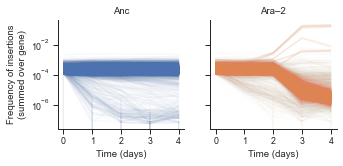

In [236]:
#making the plot:
with sns.axes_style('ticks'):
    fig,ax = plt.subplots(1,2,figsize=(5,2),sharey=True)
    for gene in range(len(names)):
        if anc_sum[gene,0,0]/greensum[0,0] >= 10**-4:
            ax[0].plot(anc_sum[gene,:,0]/greensum[0], alpha=0.02, color=sns.color_palette('deep')[0])
            ax[0].plot(anc_sum[gene,:,1]/redsum[0], alpha=0.02,color=sns.color_palette('deep')[0])
        if aram2_sum[gene,0,0]/greensum[3,0] >= 10**-4:    
            ax[1].plot(aram2_sum[gene,:,0]/greensum[3], alpha=0.01,color=sns.color_palette('deep')[1])
            ax[1].plot(aram2_sum[gene,:,1]/redsum[3], alpha=0.01,color=sns.color_palette('deep')[1])
            if aram2_sum[gene,4,0]/greensum[3,0] >= 10**-2.5:
                ax[1].plot(aram2_sum[gene,:,0]/greensum[3], alpha=0.1,color=sns.color_palette('deep')[1])
                ax[1].plot(aram2_sum[gene,:,1]/redsum[3], alpha=0.1,color=sns.color_palette('deep')[1])


    ax[0].set(xticks=[0,1,2,3,4], xlabel='Time (days)', yscale='log',ylabel='Frequency of insertions\n(summed over gene)', title='Anc')
    ax[1].set(xticks=[0,1,2,3,4], xlabel='Time (days)', yscale='log', title='Ara–2')
    sns.despine()
#     fig.savefig(repo +'/Analysis/Plots_for_paper/trajectories_comp.png', format='png', dpi=600, bbox_inches='tight')
    plt.show()
